In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler


sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (10, 6)

import sys
sys.path.append('../../utils/')
import cv_error as gfx
from utils.calidad_datos import calidad_datos

from sklearn.model_selection import KFold
import sklearn.linear_model as lm

---
# CRISP DM
---

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b9/CRISP-DM_Process_Diagram.png" width="350" height="350">

---
# Cargar Data
---

In [2]:
df = pd.read_csv('./data/kc_house_data.csv')
# Vamos a eliminar ciertas columnas que son irrelevantes para nuestroanalisis
df.drop(['zipcode', 'id', 'date'], axis = 1, inplace = True)

print('Numero de filas: {0}'.format(df.shape[0]))
print('Numero de columnas: {0}'.format(df.shape[1]))

Numero de filas: 21613
Numero de columnas: 18


In [3]:
# solicitamos información sobre los atributos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  lat            21613 non-null  float64
 15  long           21613 non-null  float64
 16  sqft_living15  21613 non-null  int64  
 17  sqft_lot15     21613 non-null  int64  
dtypes: flo

In [4]:
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Transformación de la variable objetivo

In [5]:
# Normalizamos la variable precio
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df_scaled['price'] = np.log(df['price'])

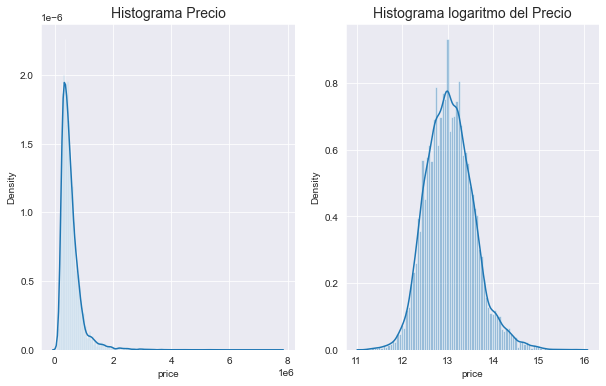

In [6]:
fig , ax = plt.subplots(1,2)
sns.distplot(df['price'], bins='fd',ax = ax[0]).set_title('Histograma Precio', size = 14)
sns.distplot(df_scaled['price'], bins = 'fd', ax = ax[1]).set_title('Histograma logaritmo del Precio', size = 14);

Text(0.5, 1.0, 'Boxplot log-Precios')

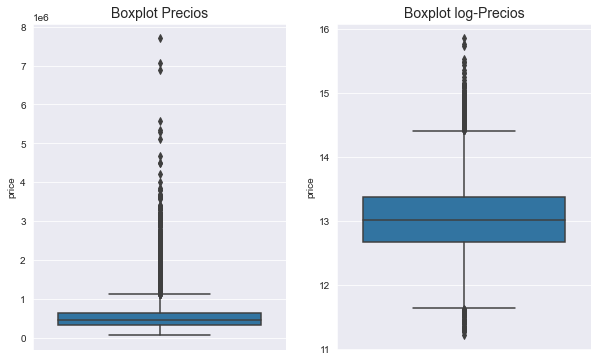

In [7]:
plt.subplot(1, 2, 1)
sns.boxplot(y = df['price']).set_title('Boxplot Precios', size=14);
plt.subplot(1, 2, 2)
sns.boxplot(y = df_scaled['price']).set_title('Boxplot log-Precios', size=14)

--- 
Norma Lp
---

In [30]:
def norma_lp(x, p):
    return sum([xi**p for xi in x])**(1/p)

x = [1,1]

norma_lp(x, 1), norma_lp(x, 2)

(2.0, 1.4142135623730951)

--- 
Ridge Regression
---

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

In [9]:
# X será nuestro conjunto de atributos. y será nuestra variable objetivo
X = df_scaled.iloc[:, 1:] # Tomamos todas las columnas menos la primera (price)
N = X.shape[0] # guardamos el número de filas (datos de entrenamiento)
y = df_scaled['price'] # asignamos como target la variable 'price'
#Separamos los subsets de test y train
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state = 63)

In [10]:
names_regressors = X_train.columns # guardamos los nombres de los atributos
alphas = np.logspace(0, 7, base = 10) # generamos un vector con los valores de la norma
coefs_ridge = [] #lista para guardar parámetros
cv_err_ridge = [] #lista para guardar parámetros
model_ridge = Ridge(fit_intercept = True) # instanciamos el modelo
tol = 0.1 # determinamos el umbral de tolerancia

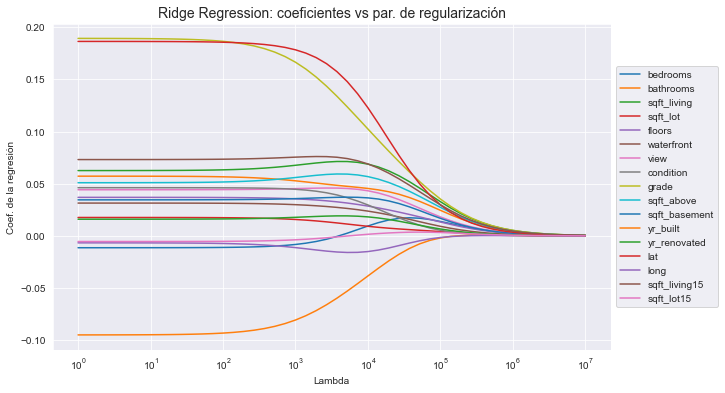

In [12]:
# para cada valor en el vector
for a in alphas:
    # estimamos el modelo con éste
    model_ridge.set_params(alpha = a)
    model_ridge.fit(X_train, y_train)
    # guardamos el coeficiente estimado
    coefs_ridge.append(model_ridge.coef_)
    # generamos su estimado de validación cruzada
    dummy,cv_err_estimates = gfx.cv_error(X_train, y_train, k = 10, method = 'ridge', alpha = a)
    cv_err_ridge.append(np.mean(cv_err_estimates)) # OJO: estamos guardando la media del error de cv para cada alpha
for y_arr, label in zip(np.squeeze(coefs_ridge).T, names_regressors):
    plt.plot(alphas, y_arr, label = label)
plt.legend()
plt.xscale("log")
plt.title("Ridge Regression: coeficientes vs par. de regularización",
size = 14)
plt.xlabel('Lambda')
plt.ylabel('Coef. de la regresión')
plt.axis("tight")
plt.legend(loc="center left", bbox_to_anchor=(1, .5));

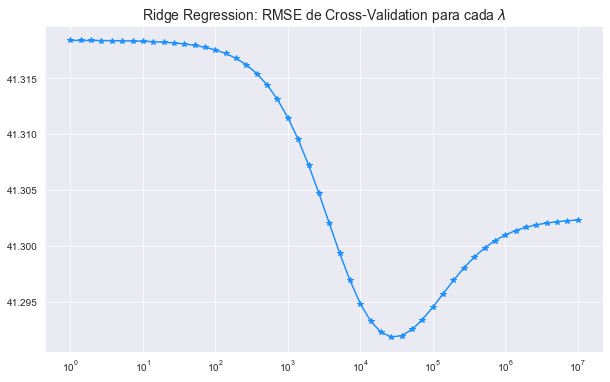

In [14]:
plt.plot(alphas, np.sqrt(cv_err_ridge),"*-", color='dodgerblue')
plt.xscale("log")
plt.title("Ridge Regression: RMSE de Cross-Validation para cada $\lambda$", fontsize = 14);

In [15]:
alphas_ = np.logspace(0, 7, base = 10)
ridge_cv = RidgeCV(cv = 10)
model_ridge = ridge_cv.fit(X_train, y_train)

In [17]:
def report_regularization(model, X_test, y_test):
    print('Valor del parámetro de regularización: {0}'.format(model.alpha_))
    print('Coeficientes finales: \n{0}'.format(model.coef_))
    y_hat = model.predict(X_test)
    print('R-squared: {0}'.format(r2_score(y_test,y_hat)))
    print('Mean Squared Error: {0}'.format(mean_squared_error(y_test, y_hat)))

    
report_regularization(ridge_cv, X_test, y_test)

Valor del parámetro de regularización: 10.0
Coeficientes finales: 
[-0.01130049  0.05717332  0.06264874  0.01764058  0.03692392  0.03143451
  0.04422176  0.04616988  0.18895082  0.05101663  0.03455404 -0.09467497
  0.01602423  0.18624593 -0.0067097   0.07316506 -0.00536286]
R-squared: 0.7685417941024782
Mean Squared Error: 0.06231291960423319


---
Lasso Regression
---

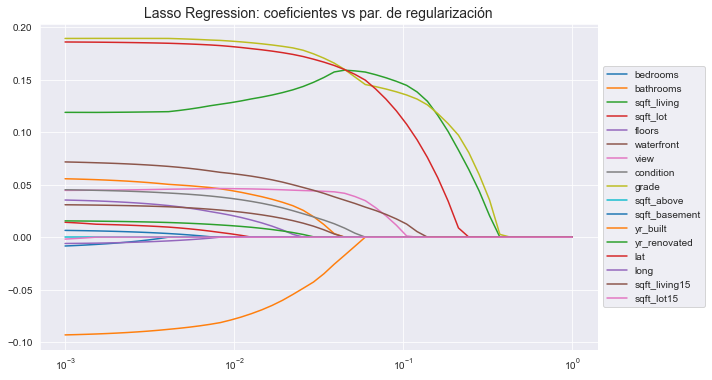

In [18]:
from sklearn.linear_model import Lasso, LassoCV

names_regressors = X.columns
alphas_ = np.logspace(0, -3, base = 10)
coefs_lasso = []
cv_err_lasso = []
model_lasso = Lasso(fit_intercept = True)
for a in alphas_:
    model_lasso.set_params(alpha = a)
    model_lasso.fit(X_train, y_train)
    coefs_lasso.append(model_lasso.coef_)
    dummy,cv_err_estimates = gfx.cv_error(X_train,y_train,k = 10, method = 'lasso', alpha = a)
    cv_err_lasso.append(np.mean(cv_err_estimates))
for y_arr, label in zip(np.squeeze(coefs_lasso).T, names_regressors):
    plt.plot(alphas_, y_arr, label = label)
    
plt.legend()
plt.xscale('log')
plt.title("Lasso Regression: coeficientes vs par. de regularización",
fontsize = 14)
plt.axis("tight")
plt.legend(loc = "center left", bbox_to_anchor=(1, .5));    
    

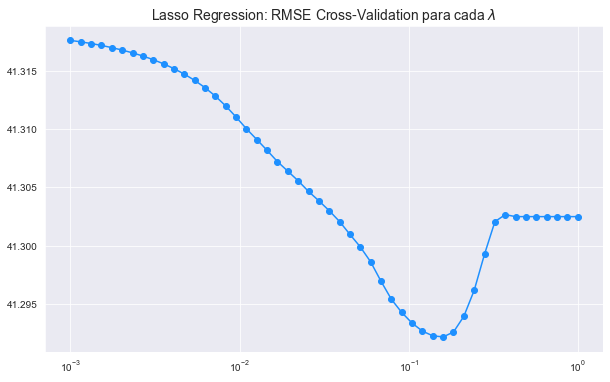

In [19]:
plt.plot(alphas_, np.sqrt(cv_err_lasso),'o-',color='dodgerblue')
plt.xscale("log")
plt.title("Lasso Regression: RMSE Cross-Validation para cada $\lambda$", fontsize = 14);

In [21]:
alphas_ = np.logspace(0, -3, base = 10)
lasso_cv = LassoCV()
model_lasso = lasso_cv.fit(X_train, y_train)
report_regularization(model_lasso, X_test, y_test)

Valor del parámetro de regularización: 0.0003753797351375845
Coeficientes finales: 
[-0.01024032  0.05663014  0.11897972  0.01634357  0.03634553  0.03122292
  0.04432799  0.04579056  0.18927954  0.          0.00698097 -0.09423091
  0.01580353  0.18619272 -0.00642786  0.07259197 -0.0040628 ]
R-squared: 0.768539353019913
Mean Squared Error: 0.062313576789754195


---
Elastic Net
---

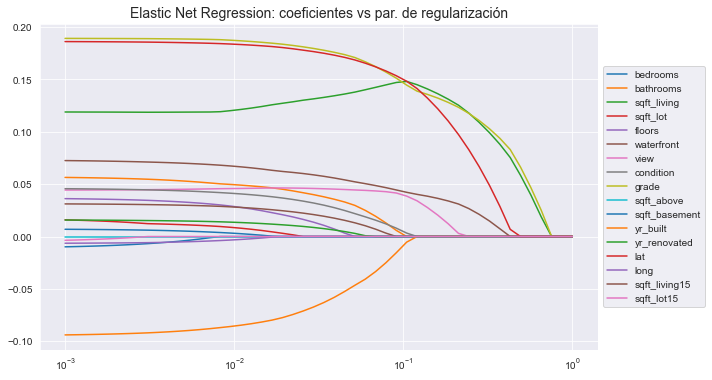

In [22]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
names_regressors = X.columns
alphas_ = np.logspace(0, -3, base = 10)
coefs_elastic_net = []
cv_err_elastic_net = []
model_elastic_net = ElasticNet(fit_intercept = True)
for a in alphas_:
    model_elastic_net.set_params(alpha = a)
    model_elastic_net.fit(X_train, y_train)
    coefs_elastic_net.append(model_elastic_net.coef_)
    dummy,cv_err_estimates = gfx.cv_error(X_train,y_train,k = 10, method = 'enet', alpha = a)
    cv_err_elastic_net.append(np.mean(cv_err_estimates))

for y_arr, label in zip(np.squeeze(coefs_elastic_net).T, names_regressors):
    plt.plot(alphas_, y_arr, label = label)

plt.legend()
plt.xscale("log")
plt.title("Elastic Net Regression: coeficientes vs par. de regularización", fontsize = 14)
plt.axis("tight")
plt.legend(loc = "center left",
bbox_to_anchor=(1, .5));

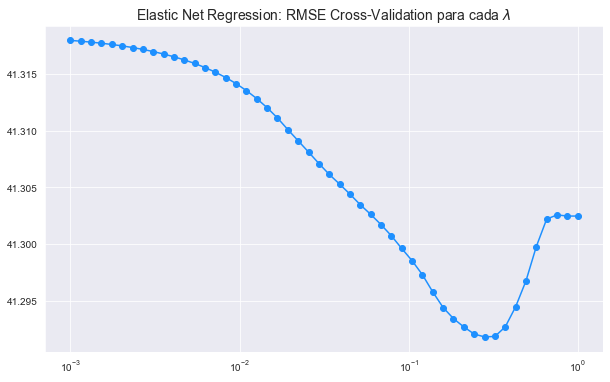

In [24]:
plt.plot(alphas_, np.sqrt(cv_err_elastic_net),"o-", color='dodgerblue')
plt.xscale("log")
plt.title("Elastic Net Regression: RMSE Cross-Validation para cada $\lambda$", fontsize = 14);

In [25]:
alphas_ = np.logspace(0, -3, base = 10)
elastic_cv = ElasticNetCV(cv = 10)
model_elastic = elastic_cv.fit(X_train, y_train)
report_regularization(model_elastic, X_test, y_test)

Valor del parámetro de regularización: 0.0007507594702751691
Coeficientes finales: 
[-0.01020259  0.05662165  0.11892443  0.01633775  0.03635761  0.03121637
  0.04433303  0.04578218  0.18915541  0.          0.0070188  -0.09414242
  0.01581814  0.18614231 -0.00645338  0.07265358 -0.00404842]
R-squared: 0.768536429557952
Mean Squared Error: 0.06231436384091725
